<a href="https://colab.research.google.com/github/magomeda228/Deep-Learning/blob/main/Word2Vec_and_Skip_Gram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import random
import warnings
from collections import Counter
from typing import List, Tuple

import numpy as np
import torch
from torch import nn, optim
from tqdm.auto import tqdm, trange
import torch.optim as optim
import torch.nn as nn

warnings.filterwarnings("ignore")

In [2]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip
!unzip text8.zip
!rm text8.zip

--2025-02-01 12:19:21--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.200.152, 52.217.134.16, 52.217.236.216, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.200.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  29.1MB/s    in 1.0s    

2025-02-01 12:19:22 (29.1 MB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  text8.zip
  inflating: text8                   


In [3]:
with open("text8") as f:
    text = f.read()

print(text[:100])

 anarchism originated as a term of abuse first used against early working class radicals including t


In [4]:
!wget https://raw.githubusercontent.com/hse-ds/iad-deep-learning/master/2022/seminars/sem08/utils.py

--2025-02-01 12:19:27--  https://raw.githubusercontent.com/hse-ds/iad-deep-learning/master/2022/seminars/sem08/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1511 (1.5K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   1.48K  --.-KB/s    in 0s      

2025-02-01 12:19:28 (30.4 MB/s) - ‘utils.py’ saved [1511/1511]



In [5]:
import utils

words = utils.preprocess(text)
print(f"Beginning of the text: {words[:30]}")
print(f"Total words in text: {len(words)}")
print(f"Unique words: {len(set(words))}")

Beginning of the text: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']
Total words in text: 16680599
Unique words: 63641


In [6]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]


In [7]:
threshold = 1e-5
word_counts = Counter(int_words)  # dictionary with number of appearances for each word
print(f"42-th word appears in the text {word_counts[42]} times")

# discard some frequent words, according to the subsampling method
# create a new list of words for training
train_words = []
for int_w in tqdm(int_words):
  if random.random() < (threshold / (word_counts[int_w] / len(int_words))) ** 0.5:
    train_words.append(int_w)
  else:
    continue

# YOUR CODE

42-th word appears in the text 32433 times


  0%|          | 0/16680599 [00:00<?, ?it/s]

In [8]:
print(int_words[:15])
print(train_words[:15])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133]
[3080, 3133, 127, 10571, 27349, 854, 15067, 58112, 854, 3580, 194, 10712, 2731, 2757, 567]


In [9]:
def get_target(words: List[int], idx: int, window_size: int = 5) -> List[int]:
    """
    Get a list of words in a random-sized window around an index.

    :param words: a text represented as a sequence of words indices
    :param idx: index of the central word that is used to make a batch
    :param window_size: controls the size of the window for each word
    :return: list of words in a window of a window_size size
    """
    r = random.randint(1, window_size)
    target = words[max(0, idx - r):idx] + words[idx + 1:min(len(words),idx + r+1)]
    # YOUR CODE HERE
    return target

In [10]:
int_text = [i for i in range(10)]
idx = 5
target = get_target(int_text, idx=idx, window_size=5)
print("Input: ", int_text)
print(f"Index of interest: {idx}")
print("Target: ", target)

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Index of interest: 5
Target:  [1, 2, 3, 4, 6, 7, 8, 9]


In [11]:
def get_batches(
    words: List[int], batch_size: int, window_size: int = 5
) -> Tuple[List[int], List[int]]:
    """
    Create a generator of word batches as a tuple (inputs, targets)
    """
    for i in range(0, len(words) // batch_size * batch_size, batch_size):
        x, y = [], []
        batch = words[i : i + batch_size]
        for j in range(len(batch)):
            batch_x = batch[j]
            batch_y = get_target(words, i + j, window_size)
            y.extend(batch_y)
            x.extend([batch_x] * len(batch_y))
        yield x, y

In [12]:
int_text = [5233, 3080, 11, 5, 194, 1, 3133, 45, 58]
batch_gen = get_batches(int_text, batch_size=4, window_size=5)
x, y = next(batch_gen)

print(f"x: {x}")
print(f"y: {y}\n")

x, y = next(batch_gen)

print(f"x: {x}")
print(f"y: {y}\n")

x: [5233, 3080, 3080, 3080, 11, 11, 11, 11, 11, 11, 5, 5, 5, 5]
y: [3080, 5233, 11, 5, 5233, 3080, 5, 194, 1, 3133, 3080, 11, 194, 1]

x: [194, 194, 194, 194, 1, 1, 1, 1, 1, 1, 1, 3133, 3133, 3133, 3133, 45, 45]
y: [11, 5, 1, 3133, 3080, 11, 5, 194, 3133, 45, 58, 194, 1, 45, 58, 3133, 58]



In [13]:
def cosine_similarity(
    embedding: nn.Module,
    valid_size: int = 16,
    valid_window: int = 100,
    device: str = "cpu",
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Computes cosine similarity between validation words and words in the embedding matrix.

    :param embedding: instance of torch.nn.Embedding module
    :param valid_size: number of words to find closest words to
    :param valid_window: number of words to draw examples from
    :param device: device to execute computations on
    :return: tensor of validation examples indices and tensor similarities to closest words
    """

    # Here we're calculating the cosine similarity between some random words and
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.

    # sim = (a . b) / |a||b|

    embed_vectors = embedding.weight

    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)

    # pick N words from our ranges (0, window) and (1000, 1000 + window). lower id implies more frequent
    valid_examples = np.array(random.sample(range(valid_window), valid_size // 2))
    valid_examples = np.append(
        valid_examples, random.sample(range(1000, 1000 + valid_window), valid_size // 2)
    )
    valid_examples = torch.LongTensor(valid_examples).to(device)

    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t()) / magnitudes

    return valid_examples, similarities

In [19]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size: int, embed_size: int):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.linear = nn.Linear(embed_size, vocab_size)

    def forward(self, x: torch.Tensor):
        out = self.linear(self.embed(x))
        return out

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print_every = 1000
steps = 0
n_epochs = 5
batch_size = 1024
embedding_dim = 128

model = SkipGram(len(vocab_to_int), embedding_dim)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

for e in trange(n_epochs, leave=True, desc="Epoch number"):
    pbar = tqdm(
        get_batches(train_words, batch_size),
        leave=False,
        desc="Batch number",
        total=len(train_words) // batch_size,
    )

    # get input and target batches
    for inputs, targets in pbar:
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)

        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:
            # getting examples and similarities
            valid_examples, valid_similarities = cosine_similarity(
                model.embed, device=device
            )
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to("cpu"), closest_idxs.to(
                "cpu"
            )
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][
                    1:
                ]
                print(int_to_vocab[valid_idx.item()] + " | " + ", ".join(closest_words))
            print("...")

Epoch number:   0%|          | 0/5 [00:00<?, ?it/s]

Batch number:   0%|          | 0/4517 [00:00<?, ?it/s]

eight | largest, unforgiving, iconography, charlton, moheli
who | eliminated, hourglass, lustre, flaps, detector
other | bathing, tar, moldova, alys, vin
often | michener, iers, guerilla, bayer, back
all | judean, ordinal, applause, halfdan, drexler
american | amritsar, shoots, mukti, presidents, chauffeur
would | toshiki, mongol, noisy, reagents, qa
are | fanpage, fabricius, martyred, documentary, neville
square | raft, scherzo, barometer, makes, trolley
arts | creepy, paternoster, venue, stability, indexes
lived | rose, duddy, directrix, ignaz, omnia
accepted | schichau, annalen, moves, residue, raging
derived | cursed, ppp, aunts, nonhuman, anthropologist
http | gangetic, xxiv, postcards, cambodian, civilisations
assembly | ssc, equalization, built, latium, chance
behind | gigue, samir, weighty, mingle, rope
...
where | ideation, basically, overseer, civic, celta
as | davids, partisan, revolutions, blowout, bloemfontein
s | dessert, rams, satam, kenesaw, boudicca
however | myrtle, s

Batch number:   0%|          | 0/4517 [00:00<?, ?it/s]

states | constitution, disneyland, ntc, charter, warship
world | ministered, outflow, bred, fansites, essaioi
united | leverett, chided, capetian, dickie, fart
when | tether, romanticized, pathet, reason, restatement
seven | two, three, m, five, zero
one | four, cartago, zero, two, three
may | bleeding, confirmed, training, neurotoxin, baldness
so | annales, portraiture, xuan, exodus, elect
report | teeming, weaver, caribe, earthrise, rajah
placed | smoother, purim, remix, cantacuzenus, feared
prince | duke, vlaams, anakkale, coco, jailed
san | tobin, antiarrhythmic, hahnemann, doomsday, iphigenia
pope | benedict, paternal, bussy, byzantine, xiii
pressure | psychics, infinitives, penitentiary, apostolicity, mambo
hold | revised, least, unused, behavior, punches
mean | negation, glut, something, inclined, elaborated
...
over | interdiction, heliports, drumhead, rmi, breathtaking
called | eritreans, linden, exponent, plaine, codeword
than | floats, genomes, downwards, keyword, lund
be | 

Batch number:   0%|          | 0/4517 [00:00<?, ?it/s]

however | aggrieved, actually, disadvantages, peaceful, unlawful
they | their, adhesion, reconsideration, regurgitate, inexpensive
it | make, grapple, stack, flocks, convenient
would | to, toshiki, knows, mackerel, mongol
not | we, does, strange, go, renounce
often | chilling, abiword, back, any, flashbacks
as | mifepristone, dalit, blob, extremity, kick
when | salian, tether, to, priam, payouts
lived | rose, ignaz, rriais, illness, ambassador
prince | duke, nephew, vlaams, empress, nueva
police | avenger, armed, attacks, guard, excuses
shown | common, homophones, mst, sheba, parseval
discovered | screwing, geyser, milky, shred, niki
resources | developed, natural, theme, largest, crna
question | gogo, fari, therein, vibrio, excesses
test | hizb, tms, login, bastien, rowing
...
i | t, we, schnauzer, q, r
also | opcode, shows, organizations, fishes, forefront
often | abiword, certain, chilling, than, any
between | ventilated, alphabets, milliseconds, overlap, prior
into | vesicles, atta

Batch number:   0%|          | 0/4517 [00:00<?, ?it/s]

if | that, case, implies, function, not
four | one, five, six, two, seven
an | useful, a, subscript, semimajor, cartan
it | that, happens, inferred, point, everything
b | d, laureate, politician, actor, composer
zero | two, five, three, six, nine
war | forces, army, warfare, gatling, novorossiysk
so | suppose, thou, edict, elect, hunting
except | quechua, gallardo, pronunciation, clause, ignoble
test | tests, cricket, biostatistics, lanka, hizb
something | evocation, expressions, ditko, say, oblivious
older | median, distinguishable, average, size, age
taking | bicentennial, stung, fights, shopkeeper, absence
joseph | d, harwood, harrisburg, girolamo, evelyn
units | unit, circumvention, cgs, radiocommunication, measurement
bible | prophets, accentuation, matthew, easton, chamada
...
often | certain, are, more, than, such
see | topics, of, list, in, blot
states | united, u, constitution, state, british
an | subscript, semimajor, useful, a, spoiling
american | hispanic, african, pioneer,

Batch number:   0%|          | 0/4517 [00:00<?, ?it/s]

many | some, most, few, especially, well
was | had, later, after, his, became
been | recent, havens, soared, has, goitre
four | five, one, three, two, eight
these | are, have, writable, than, many
called | special, known, similar, is, group
which | the, subcode, bosom, is, granary
were | was, their, germans, many, had
stage | theatre, stages, synthesizer, sonorous, swung
lived | rose, met, ignaz, aymara, menhir
account | narrative, prophetic, isaiah, desolation, hasdai
dr | sheen, hale, norwood, letitia, handmaid
heavy | coax, asg, forces, ifvs, ghosting
http | www, com, html, org, htm
cost | costs, profitability, sales, price, cheaper
applications | application, functionality, clients, technologies, directx
...
after | returned, his, went, was, until
his | he, him, was, himself, friend
and | the, of, to, in, as
some | are, many, reasons, there, these
would | longer, did, they, but, to
were | their, however, was, disperse, germans
often | such, more, tend, certain, usually
more | than,

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [22]:
embeddings = model.embed.weight.to("cpu").data.numpy()

In [23]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

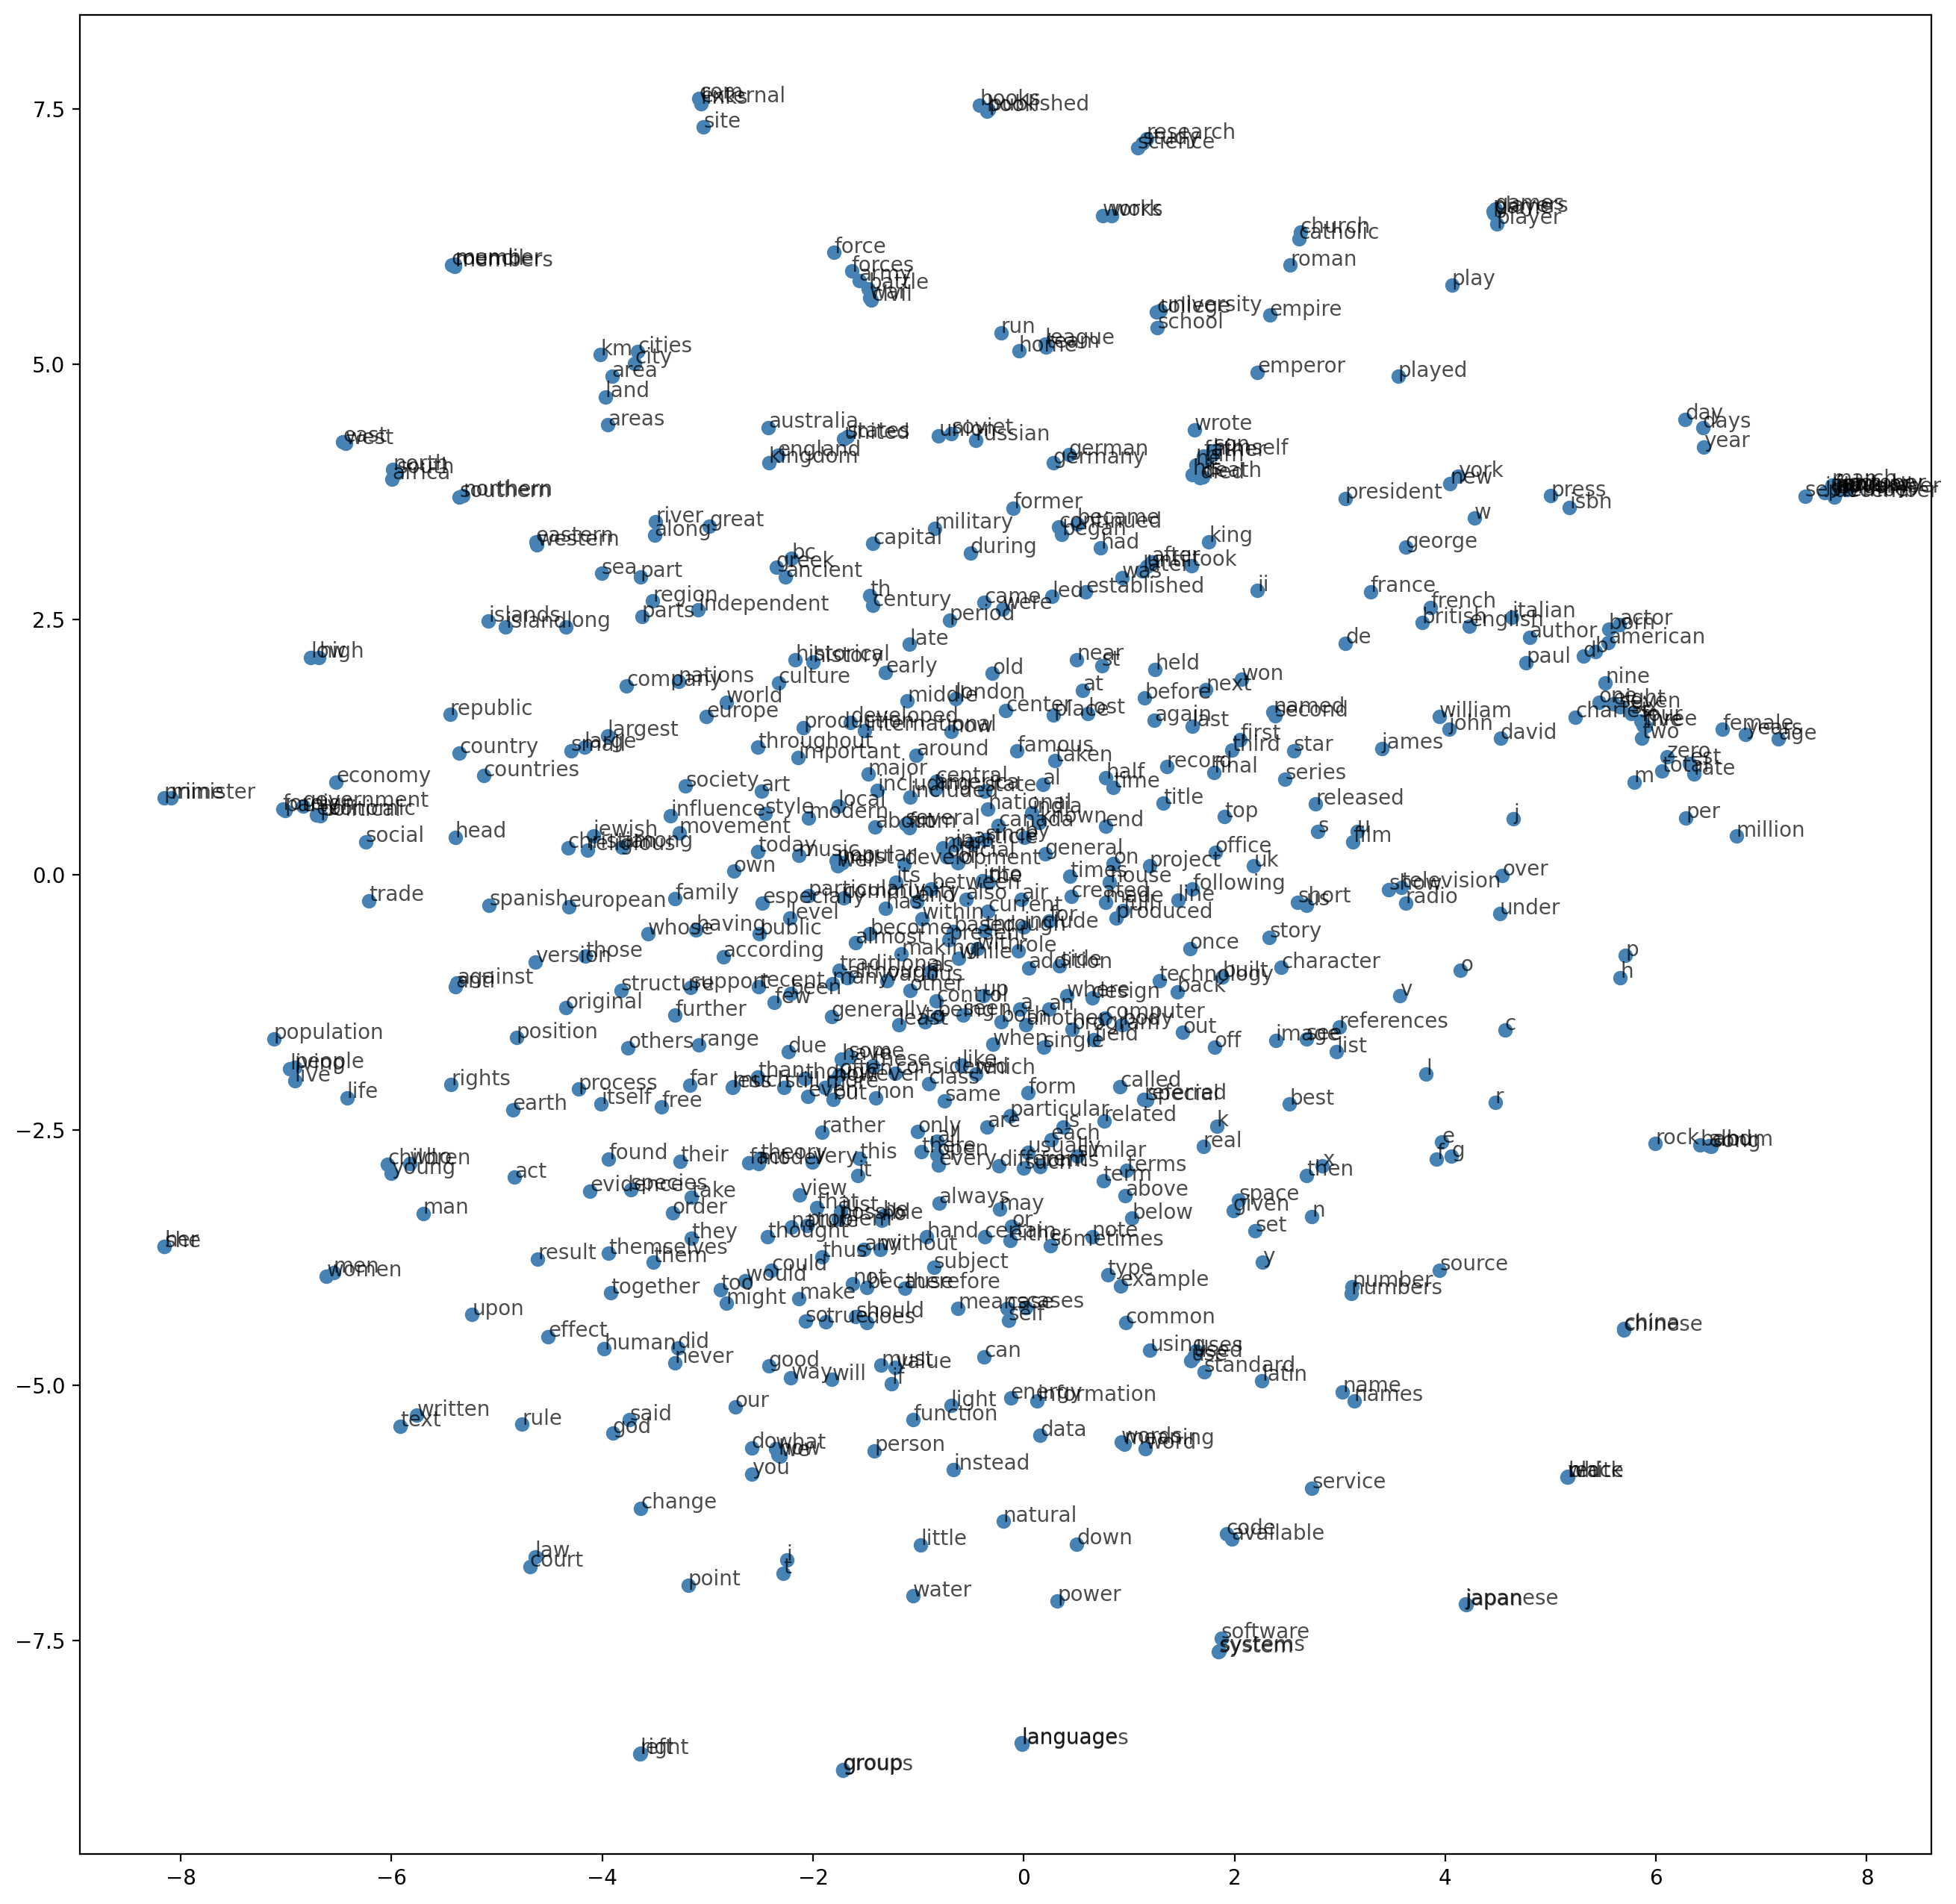

In [24]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color="steelblue")
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)